In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import io


In [3]:
API_KEY = "YOUR_API_KEY"
BASE_URL = "https://api.stlouisfed.org/fred"
aws_access_key_id = 'YOUR_KEY_ID'
aws_secret_access_key = 'YOUR_ACCESS_KEY'
endpoint_url = 'YOUR_ENDPOINT'
bucket_name = 'fred'

s3 = boto3.resource(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url=endpoint_url
)
bucket = s3.Bucket(bucket_name)

obj = bucket.Object("metadata/all_series_metadata.csv")
existing_df = pd.read_csv(io.BytesIO(obj.get()['Body'].read()))

meta_data_date = existing_df[~existing_df['title'].str.upper().str.contains("DISCONTINUED")].copy()

meta_data_date['last_updated'] = pd.to_datetime(meta_data_date['last_updated'], errors='coerce')

df_daily_amount = meta_data_date[meta_data_date['frequency'].str.contains('Daily', na=False)]

C:\Users\flore\AppData\Local\Temp\ipykernel_32156\1778474582.py:17: DtypeWarning: Columns (2,3,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  existing_df = pd.read_csv(io.BytesIO(obj.get()['Body'].read()))
C:\Users\flore\AppData\Local\Temp\ipykernel_32156\1778474582.py:21: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  meta_data_date['last_updated'] = pd.to_datetime(meta_data_date['last_updated'], errors='coerce')


,id,title,observation_start,observation_end,frequency,units,seasonal_adjustment,last_updated,notes,realtime_start,realtime_end
500,ISRRECDM,OECD based Recession Indicators for Israel fro...,1995-02-01,2022-09-30,"Daily, 7-Day",+1 or 0,Not Seasonally Adjusted,2022-12-09 15:03:05-06:00,This time series is an interpretation of Organ...,NaN,NaN
3508,ISRRECDP,OECD based Recession Indicators for Israel fro...,1995-02-01,2022-09-30,"Daily, 7-Day",+1 or 0,Not Seasonally Adjusted,2022-12-09 15:03:06-06:00,This time series is an interpretation of Organ...,NaN,NaN
3897,ITARECD,OECD based Recession Indicators for Italy from...,1960-02-01,2022-08-31,"Daily, 7-Day",+1 or 0,Not Seasonally Adjusted,2022-12-09 14:48:03-06:00,This time series is an interpretation of Organ...,NaN,NaN
3921,ITARECDM,OECD based Recession Indicators for Italy from...,1960-02-01,2022-08-31,"Daily, 7-Day",+1 or 0,Not Seasonally Adjusted,2022-12-09 14:48:06-06:00,This time series is an interpretation of Organ...,NaN,NaN
3945,ITARECDP,OECD based Recession Indicators for Italy from...,1960-02-01,2022-08-31,"Daily, 7-Day",+1 or 0,Not Seasonally Adjusted,2022-12-09 14:48:08-06:00,This time series is an interpretation of Organ...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
653353,DTP30F47,30-Year 0.875% Treasury Inflation-Indexed Bond...,NaN,NaN,Daily,%,NSA,2025-05-28 06:03:09-05:00,NaN,2025-05-28,2025-05-28
653625,CBLTCUSD,Coinbase Litecoin,NaN,NaN,"Daily, 7-Day",U.S. $,NSA,2025-05-28 19:04:02-05:00,NaN,2025-05-28,2025-05-28
653626,CBETHUSD,Coinbase Ethereum,NaN,NaN,"Daily, 7-Day",U.S. $,NSA,2025-05-28 19:04:02-05:00,NaN,2025-05-28,2025-05-28
653627,CBBCHUSD,Coinbase Bitcoin Cash,NaN,NaN,"Daily, 7-Day",U.S. $,NSA,2025-05-28 19:04:01-05:00,NaN,2025-05-28,2025-05-28


In [4]:
s3 = boto3.resource(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url=endpoint_url
)
bucket = s3.Bucket(bucket_name)

# Set of valid daily series IDs
daily_series_ids = set(df_daily_amount['id'].astype(str))

# Collect matching dataframes
df_list = []
matched_count = 0

for obj in bucket.objects.all():
    key = obj.key
    # Skip files outside 'observations/' if necessary
    if not key.startswith("observations/") or not key.endswith(".csv"):
        continue

    series_id = key.split("/")[-1].replace(".csv", "")
    if series_id in daily_series_ids:
        #print(f"Found daily series: {series_id}")
        body = obj.get()['Body']
        df = pd.read_csv(body)
        df['series_id'] = series_id
        df_list.append(df)
        matched_count += 1

# Combine into one DataFrame
df_daily = pd.concat(df_list, ignore_index=True)
print(f"Loaded {matched_count} daily series into df_daily")

Loaded 1168 daily series into df_daily


In [5]:
df_daily = df_daily.drop('id', axis=1) 


In [6]:
df_daily = df_daily.dropna()

In [7]:
df_daily = df_daily.rename(columns={'series_id': 'id'})


In [8]:
dupes = df_daily.duplicated(subset=['date', 'id'])
print("Number of duplicates:", dupes.sum())

df_nodupes = df_daily.drop_duplicates(subset=['date', 'id'], keep='last')

df_wide = df_nodupes.pivot(index='date', columns='id', values='value')
df_wide.index = pd.to_datetime(df_wide.index)

Number of duplicates: 0


id,4BIGEURORECD,4BIGEURORECDM,4BIGEURORECDP,AAA10Y,AAAFF,AB1020AAAMT,AB1020AAVOL,AB14AAAMT,AB14AAVOL,AB2140AAAMT,...,VXEWZCLS,VXGOGCLS,VXGSCLS,VXIBMCLS,VXNCLS,VXVCLS,WLEMUINDXD,ZAFRECD,ZAFRECDM,ZAFRECDP
date,,,,,,,,,,,,,,,,,,,,,
1854-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,771.45,NaN,NaN,NaN
2025-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,192.85,NaN,NaN,NaN
2025-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,170.62,NaN,NaN,NaN


In [9]:
target = 'DEXKOUS'

correlations = df_wide.corr()[target].abs().sort_values(ascending=False)

# top 30 most correlated
top_series = correlations[1:31].index.tolist()


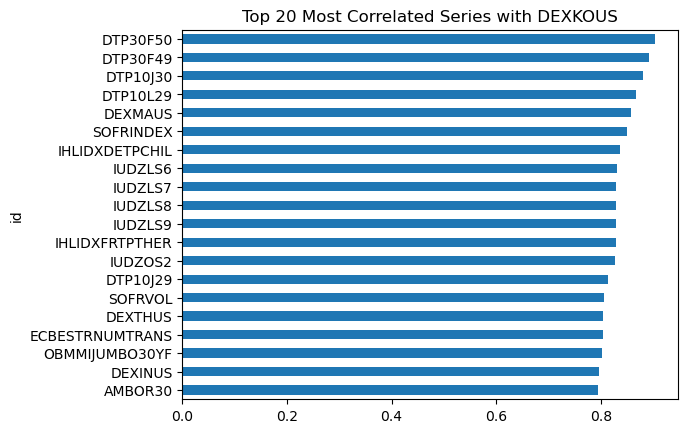

In [10]:
correlations[1:21].plot(kind='barh', title='Top 20 Most Correlated Series with DEXKOUS')
plt.gca().invert_yaxis()
plt.show()


In [11]:
var = correlations[0:31].index.tolist()
df_var = df_wide[var]
df_var

id,DEXKOUS,DTP30F50,DTP30F49,DTP10J30,DTP10L29,DEXMAUS,SOFRINDEX,IHLIDXDETPCHIL,IUDZLS6,IUDZLS7,...,IHLIDXDETPSPOR,IHLIDXFRTPPHSU,OBMMIC30YFLVGT80FB680A699,OBMMIC30YFLVGT80FB700A719,OBMMIC30YFLVGT80FGE740,OBMMIC30YFLVGT80FB720A739,OBMMIC30YFLVLE80FB700A719,OBMMIC30YFLVLE80FGE740,OBMMIC30YFLVLE80FB720A739,OBMMIC30YFNA
date,,,,,,,,,,,,,,,,,,,,,
1854-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-27,NaN,2.645,2.638,1.540,1.379,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Set threshold (e.g., keep columns with at least 90% non-NaNs)
threshold = 0.01
valid_cols = df_wide[var].isna().mean() < (1 - threshold)

# Apply the filter
df_var_filtered = df_wide[valid_cols[valid_cols].index].copy()
df_var_filtered.dropna()

id,DEXKOUS,DTP30F50,DTP30F49,DTP10J30,DTP10L29,DEXMAUS,SOFRINDEX,IHLIDXDETPCHIL,IUDZLS6,IUDZLS7,...,IHLIDXDETPSPOR,IHLIDXFRTPPHSU,OBMMIC30YFLVGT80FB680A699,OBMMIC30YFLVGT80FB700A719,OBMMIC30YFLVGT80FGE740,OBMMIC30YFLVGT80FB720A739,OBMMIC30YFLVLE80FB700A719,OBMMIC30YFLVLE80FGE740,OBMMIC30YFLVLE80FB720A739,OBMMIC30YFNA
date,,,,,,,,,,,,,,,,,,,,,
2020-02-25,1214.45,0.174,0.177,-0.210,-0.244,4.2335,1.040574,89.69,0.68,0.70,...,92.79,95.47,3.789,3.712,3.502,3.581,3.609,3.433,3.526,3.385
2020-02-26,1213.61,0.170,0.173,-0.231,-0.258,4.2240,1.040620,89.09,0.68,0.70,...,93.05,95.40,3.846,3.722,3.495,3.591,3.620,3.427,3.515,3.392
2020-02-27,1217.03,0.158,0.161,-0.235,-0.264,4.2095,1.040666,88.42,0.67,0.70,...,93.54,95.84,3.722,3.623,3.463,3.525,3.582,3.404,3.480,3.363
2020-02-28,1214.92,0.071,0.079,-0.322,-0.343,4.2137,1.040712,89.33,0.66,0.70,...,93.99,96.42,3.633,3.613,3.381,3.481,3.557,3.338,3.425,3.328
2020-03-02,1190.89,0.086,0.093,-0.348,-0.367,4.2025,1.040850,92.28,0.66,0.70,...,95.12,96.85,3.557,3.506,3.314,3.386,3.405,3.269,3.335,3.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,1456.74,2.299,2.281,1.538,1.382,4.4218,1.184610,161.40,4.44,4.45,...,150.90,286.28,6.782,6.761,6.553,6.701,6.681,6.516,6.614,6.475
2025-03-11,1453.07,2.366,2.354,1.600,1.441,4.4100,1.184753,160.90,4.44,4.45,...,149.28,285.89,6.791,6.717,6.613,6.646,6.745,6.535,6.570,6.447
2025-03-12,1451.70,2.373,2.360,1.614,1.457,4.4255,1.184895,160.89,4.43,4.45,...,145.66,287.89,6.937,6.773,6.662,6.707,6.672,6.594,6.618,6.537


In [13]:
df_diff = df_var_filtered.diff().dropna()


In [14]:
from statsmodels.tsa.api import VAR

model = VAR(df_diff)
results = model.fit(maxlags=15, ic='aic')  # automatically picks best lag with AIC


C:\Users\flore\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, May, 2025
Time:                     20:02:27
--------------------------------------------------------------------
No. of Equations:         31.0000    BIC:                   -176.883
Nobs:                     944.000    HQIC:                  -183.093
Log likelihood:           48654.1    FPE:                6.69226e-82
AIC:                     -186.917    Det(Omega_mle):     9.03215e-83
--------------------------------------------------------------------
Results for equation DEXKOUS
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               -0.148320         0.322569           -0.460           0.646
L1.DEXKOUS                          -0.074765         0.039008           -1.917           0.05

In [16]:
lag_order = results.k_ar
forecast_input = df_diff.values[-lag_order:]

forecast = results.forecast(y=forecast_input, steps=5)

# Rebuild into DataFrame
forecast_df = pd.DataFrame(forecast, index=pd.date_range(df_var.index[-1] + pd.Timedelta(days=1), periods=5), columns=df_diff.columns)


In [17]:
last_row = df_var_filtered.dropna().iloc[-1]
forecast_actual = forecast_df.cumsum() + last_row


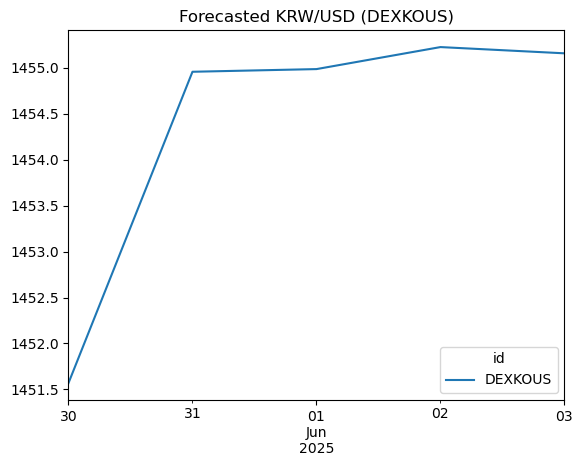

In [18]:
import matplotlib.pyplot as plt

forecast_actual[['DEXKOUS']].plot(title='Forecasted KRW/USD (DEXKOUS)')
plt.show()


C:\Users\flore\AppData\Local\Temp\ipykernel_32156\1739465229.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  actual_past = df_var[['DEXKOUS']].last('365D')


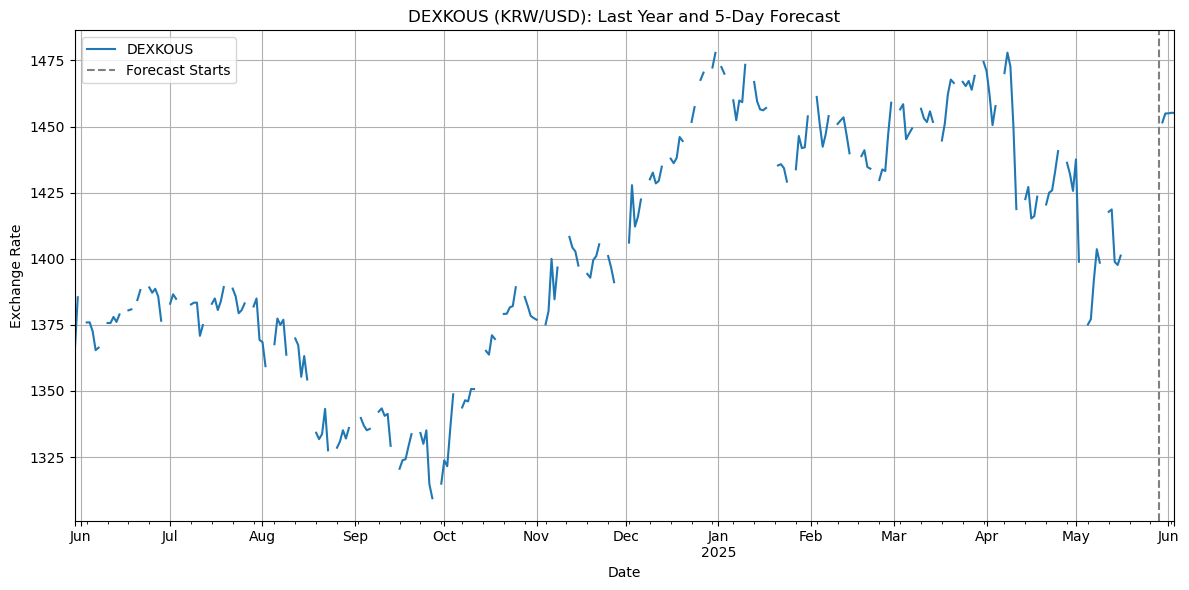

In [19]:
actual_past = df_var[['DEXKOUS']].last('365D')
df_plot = pd.concat([actual_past, forecast_actual[['DEXKOUS']]])

plt.figure(figsize=(12, 6))
df_plot.plot(ax=plt.gca(), label='Actual & Forecasted')
plt.axvline(x=actual_past.index[-1], color='gray', linestyle='--', label='Forecast Starts')
plt.title('DEXKOUS (KRW/USD): Last Year and 5-Day Forecast')
plt.ylabel('Exchange Rate')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [20]:
df = df_plot #for dash purposes